![](https://www.finplus.co.in/wp-content/uploads/2017/10/Top-Categories-In-Online-Retail-In-India.jpg)

## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Goal
We aim to segement the Customers based on (repeat freq measure) RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [57]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [58]:
# Reading the data on which analysis needs to be done
file_path = "Online Retail.xlsx"
retail = pd.read_excel(file_path, nrows=10000)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [59]:
# shape of df

retail.shape

(10000, 8)

In [60]:
 # df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    10000 non-null  object        
 1   StockCode    10000 non-null  object        
 2   Description  9958 non-null   object        
 3   Quantity     10000 non-null  int64         
 4   InvoiceDate  10000 non-null  datetime64[ns]
 5   UnitPrice    10000 non-null  float64       
 6   CustomerID   7709 non-null   float64       
 7   Country      10000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 625.1+ KB


In [61]:
# df description

retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,10000.000000,10000,10000.000000,7709.000000
mean,7.828600,2010-12-03 05:58:26.346000128,3.837412,15615.462576
min,-9360.000000,2010-12-01 08:26:00,0.000000,12395.000000
25%,1.000000,2010-12-01 17:06:00,1.250000,14388.000000
50%,2.000000,2010-12-02 18:08:00,2.510000,15605.000000
75%,8.000000,2010-12-05 10:45:00,4.210000,17228.000000
max,2880.000000,2010-12-05 16:24:00,887.520000,18239.000000
std,104.322417,NaN,14.310148,1756.540802


<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [62]:
# Calculating the Missing Values % contribution in DF

df_null = round(100 * (retail.isnull().sum()) / len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.42
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     22.91
Country         0.00
dtype: float64

In [63]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape


(7709, 8)

In [64]:
# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [65]:
retail['Quantity'].fillna(0, inplace=True)
retail['UnitPrice'].fillna(0, inplace=True)

# Convert columns to numeric
retail['Quantity'] = pd.to_numeric(retail['Quantity'], errors='coerce')
retail['UnitPrice'] = pd.to_numeric(retail['UnitPrice'], errors='coerce')

# Create the 'Amount' column
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']

In [66]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12395.0,346.10
1,12427.0,303.50
2,12431.0,358.25
3,12433.0,1919.14
4,12471.0,-17.00


In [67]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12395.0,12
1,12427.0,10
2,12431.0,14
3,12433.0,73
4,12471.0,1


In [68]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12395.0,346.10,12
1,12427.0,303.50,10
2,12431.0,358.25,14
3,12433.0,1919.14,73
4,12471.0,-17.00,1


In [69]:
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
9995,537224,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2010-12-05 16:24:00,9.95,13174.0,United Kingdom,19.90
9996,537224,22623,BOX OF VINTAGE JIGSAW BLOCKS,2,2010-12-05 16:24:00,4.95,13174.0,United Kingdom,9.90
9997,537224,21363,HOME SMALL WOOD LETTERS,2,2010-12-05 16:24:00,4.95,13174.0,United Kingdom,9.90
9998,537224,21556,CERAMIC STRAWBERRY MONEY BOX,2,2010-12-05 16:24:00,2.55,13174.0,United Kingdom,5.10


In [70]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [71]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2010-12-05 16:24:00')

In [72]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,4 days 07:58:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,4 days 07:58:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,4 days 07:58:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,4 days 07:58:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,4 days 07:58:00


In [73]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12395.0,1 days 23:49:00
1,12427.0,2 days 05:40:00
2,12431.0,4 days 06:21:00
3,12433.0,4 days 03:00:00
4,12471.0,3 days 05:47:00


In [74]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12395.0,1
1,12427.0,2
2,12431.0,4
3,12433.0,4
4,12471.0,3


In [75]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12395.0,346.10,12,1
1,12427.0,303.50,10,2
2,12431.0,358.25,14,4
3,12433.0,1919.14,73,4
4,12471.0,-17.00,1,3


#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

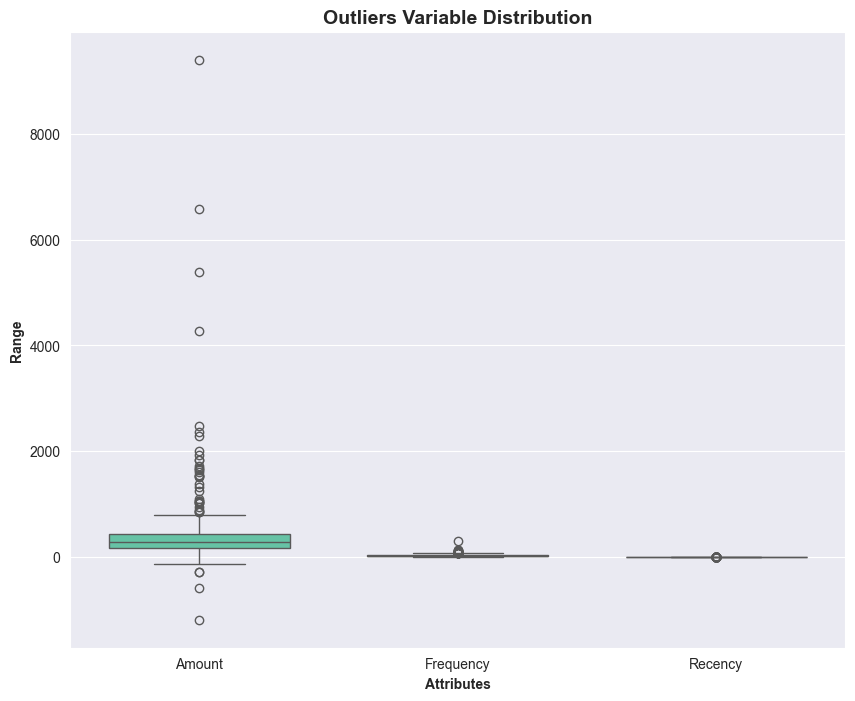

In [76]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')

In [77]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5 * IQR) & (rfm.Amount <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5 * IQR) & (rfm.Recency <= Q3 + 1.5 * IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5 * IQR) & (rfm.Frequency <= Q3 + 1.5 * IQR)]

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

In [78]:

rfm.to_csv("customer_data.csv", index=False)

In [23]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(319, 3)

In [24]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.063232,-0.451137,-0.845361
1,-0.163556,-0.534179,-0.153899
2,-0.034619,-0.368094,1.229024
3,3.641320,2.081660,1.229024
4,-0.918343,-0.907871,0.537563


<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [25]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=4)

In [26]:
kmeans.labels_

array([3, 1, 1, 0, 1, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 2, 3, 1,
       1, 1, 2, 3, 1, 1, 1, 1, 1, 0, 1, 1, 0, 3, 1, 1, 3, 0, 3, 1, 1, 1,
       1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 0, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 0, 1, 3, 3, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 3, 3, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 0, 2,
       3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 0, 2, 0, 1, 3, 1, 1, 1, 2,
       3, 1, 3, 1, 2, 1, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 3, 2, 2, 3, 1, 1, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3,
       1, 3, 1, 1, 0, 1, 3, 2, 1, 2, 2, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 3, 1, 2, 1, 2, 1, 1, 3, 1, 3, 1,
       1, 1, 3, 2, 3, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 2,
       1, 3, 3, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1,

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packa

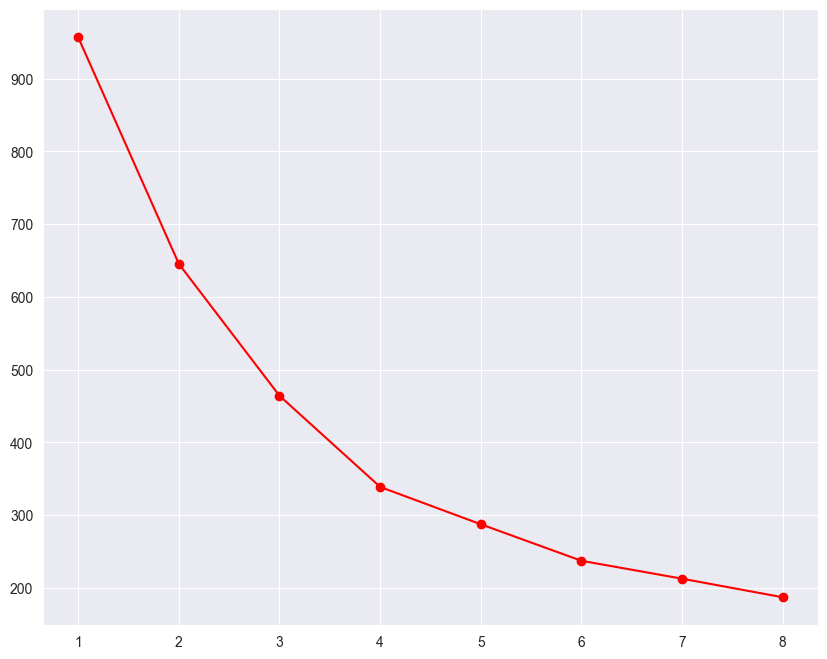

In [44]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(range_n_clusters, ssd, 'ro-')

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [45]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))



C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packa

For n_clusters=2, the silhouette score is 0.4187241098579193
For n_clusters=3, the silhouette score is 0.4543231555133118
For n_clusters=4, the silhouette score is 0.4674114196499948
For n_clusters=5, the silhouette score is 0.3364797823168139
For n_clusters=6, the silhouette score is 0.3615803856265093
For n_clusters=7, the silhouette score is 0.3679083317128012
For n_clusters=8, the silhouette score is 0.3657218941799959


C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [46]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

C:\Users\Shadab Khan\OneDrive\Documents\Major Project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(max_iter=50, n_clusters=3)

In [47]:
import joblib

joblib.dump(kmeans, 'kmeans.pkl')

['kmeans.pkl']

In [48]:
kmeans.predict(rfm_df_scaled[0:10])

array([1, 0, 0, 2, 0, 2, 0, 2, 0, 0])

In [49]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.sort_values(by='Recency').tail(20)

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
30,12947.0,304.04,17,4,0,0
275,17643.0,101.55,8,4,0,0
159,15513.0,357.00,3,4,0,0
273,17572.0,70.80,4,4,0,0
160,15525.0,313.93,57,4,0,0
270,17548.0,-141.48,7,4,0,0
268,17511.0,1825.74,24,4,2,0
266,17420.0,130.85,7,4,0,0
48,13255.0,225.70,6,4,0,0
209,16250.0,226.14,14,4,0,0


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

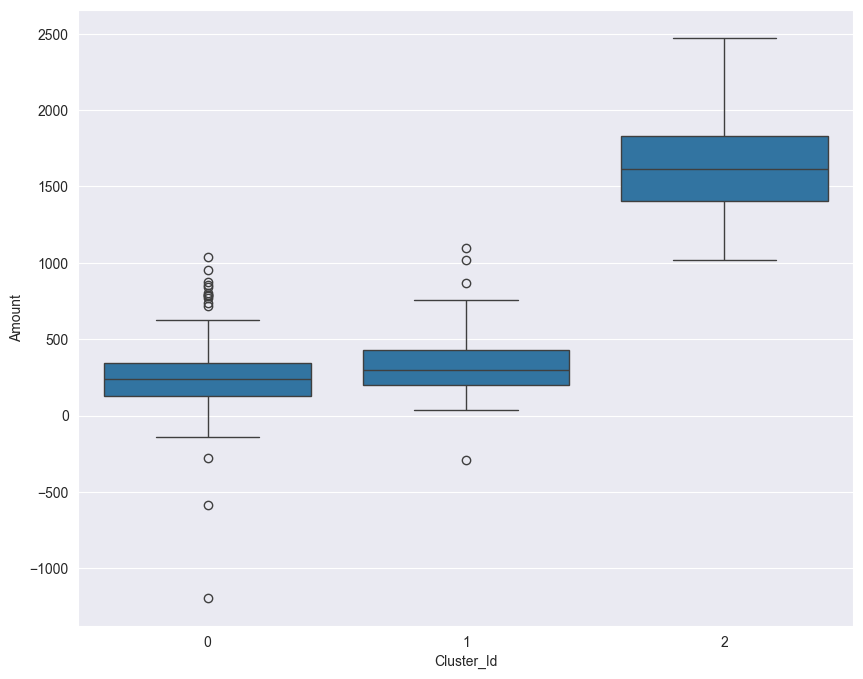

In [50]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Frequency'>

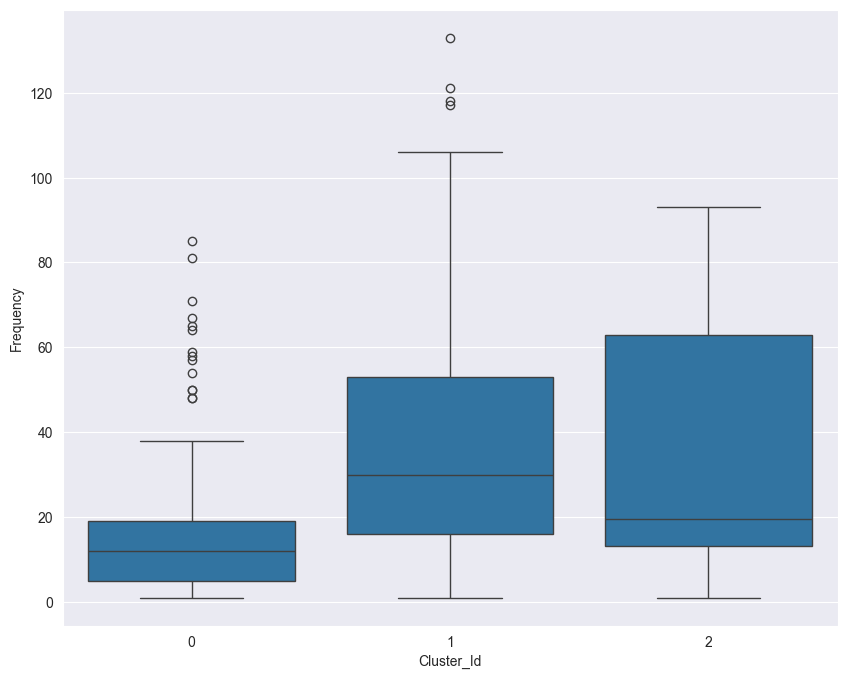

In [51]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Id', ylabel='Recency'>

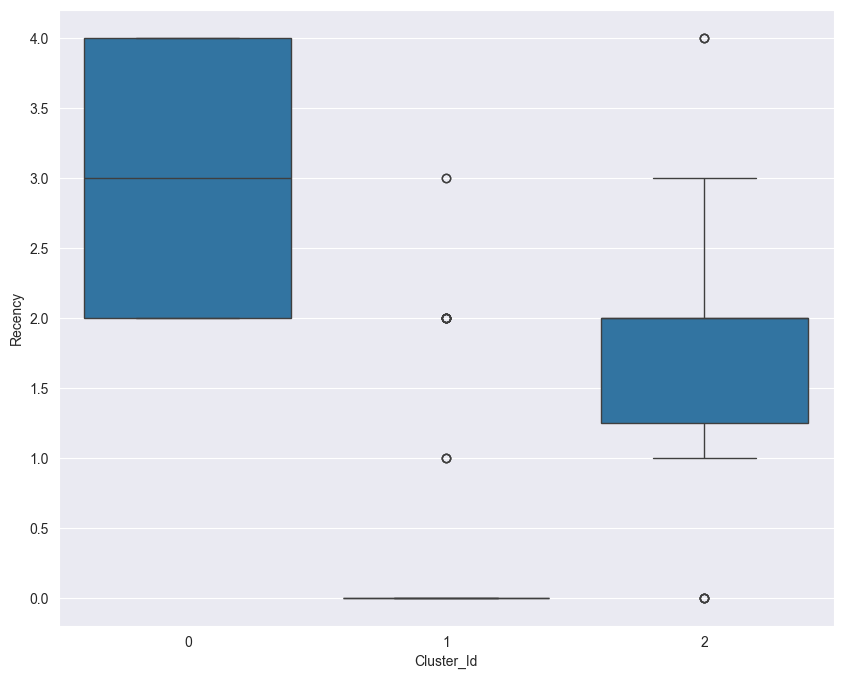

In [52]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

In [1]:
import pandas as pd
import joblib
from sklearn.cluster import AgglomerativeClustering




In [2]:
def make_hierarchical_clustering(file_path, n_clusters=3):
    df = pd.read_csv(file_path)

    # Assuming you have a pre-trained hierarchical clustering model
    hierarchical_clustering = joblib.load('hierarchical_clustering_trained.pkl')

    X_train = df[['Amount', 'Frequency', 'Recency']]
    clustering_labels = hierarchical_clustering.fit_predict(X_train)

    hierarchical_dataset = X_train.copy()
    hierarchical_dataset.loc[:, 'Cluster'] = clustering_labels

    return hierarchical_dataset